In [18]:
from matplotlib import pyplot as plt
import numpy as np
import os
import time

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# import a lot of things from keras:
# sequential model
from keras.models import Sequential

# layers
from keras.layers import  Dense, LSTM

# callback functions
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# convert data to categorial vector representation
from keras.utils import to_categorical

# nice progress bar for loading data
from tqdm.notebook import tqdm

# helper function for train/test split
from sklearn.model_selection import train_test_split

# resample signal to n samples
from scipy.signal import resample

# XML parser
import xml.etree.ElementTree as ET

# encoding and normalizing data
from sklearn.preprocessing import LabelEncoder, StandardScaler

NUM_POINTS = 32

## Function to load Data

In [19]:
# function to dynamically load data with specified parameter/resample value
def load_data(parameters):
    data = []
    for root, subdirs, files in os.walk('dataset/xml_logs'):
        if 'ipynb_checkpoint' in root:
            continue
        
        if len(files) > 0:
            for f in tqdm(files):
                if '.xml' in f:
                    fname = f.split('.')[0]
                    label = fname[:-2]
                    
                    xml_root = ET.parse(f'{root}/{f}').getroot()
                    
                    points = []
                    for element in xml_root.findall('Point'):
                        x = element.get('X')
                        y = element.get('Y')
                        points.append([x, y])
                        
                    points = np.array(points, dtype=float)
                    
                    scaler = StandardScaler()
                    points = scaler.fit_transform(points)
                    
                    resampled = resample(points, parameters)

                    data.append((label, resampled))
    return data

## Function to create models

In [20]:
# helper function to create a model
def create_model(parameterCount, labels):
    # Define the model
    model = Sequential()

    # add LSTM layer
    # input shape is (length of an individual sample, dimensions of the sample)
    # in our case: two dimensions, as we have X and Y coordinates
    model.add(LSTM(parameterCount, input_shape=(parameterCount, 2)))

    # add dense layer to do machine learning magic
    model.add(Dense(32, activation='relu'))

    # here, you can add more layers and maybe a dropout for better performance

    # softmax layer for classification
    model.add(Dense(len(set(labels)), activation='softmax'))

    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

## function to train models and return histories

In [21]:
# callback functions
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)

# function to train a model
def train_model(model, name, X_train, X_test, y_train, y_test):
    history = model.fit(
        X_train,
        y_train,
        epochs=50,
        batch_size=32,
        validation_data=(X_test, y_test),
        verbose=1,
        callbacks=[reduce_lr, stop_early]
    )

    return {"history": history, "name": name}

## Load, create and train all Models

In [22]:
# combines previous functions to preprocess, create and evaluate multiple models
def create_and_train_models(parameters):
    models = []
    histories = []
    for parameter in parameters:
        data = load_data(parameter)
        # Prepare the data
        labels = [sample[0] for sample in data]

        encoder = LabelEncoder()
        labels_encoded = encoder.fit_transform(labels)

        y = to_categorical(labels_encoded)

        sequences = [sample[1] for sample in data]
        X = np.array(sequences)
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        model = create_model(parameter, labels)

        history = train_model(model, str(parameter) + " Params",  X_train, X_test, y_train, y_test)

        named_model = {"model": model, "name": str(parameter) + " Params", "X_test": X_test, "y_test": y_test}

        models.append(named_model)

        histories.append(history)

    return models, histories

trained_models, histories = create_and_train_models([64, 32, 16, 8])

  0%|          | 0/160 [00:00<?, ?it/s]

Epoch 1/50
4/4 [==============================] - 2s 212ms/step - loss: 2.7788 - accuracy: 0.0469 - val_loss: 2.7907 - val_accuracy: 0.0625 - lr: 0.0010
Epoch 2/50
4/4 [==============================] - 0s 27ms/step - loss: 2.7145 - accuracy: 0.1328 - val_loss: 2.7419 - val_accuracy: 0.0938 - lr: 0.0010
Epoch 3/50
4/4 [==============================] - 0s 26ms/step - loss: 2.6614 - accuracy: 0.2422 - val_loss: 2.6997 - val_accuracy: 0.0938 - lr: 0.0010
Epoch 4/50
4/4 [==============================] - 0s 26ms/step - loss: 2.6005 - accuracy: 0.3047 - val_loss: 2.6508 - val_accuracy: 0.1562 - lr: 0.0010
Epoch 5/50
4/4 [==============================] - 0s 28ms/step - loss: 2.5309 - accuracy: 0.3203 - val_loss: 2.5923 - val_accuracy: 0.1562 - lr: 0.0010
Epoch 6/50
4/4 [==============================] - 0s 28ms/step - loss: 2.4435 - accuracy: 0.3672 - val_loss: 2.5253 - val_accuracy: 0.2500 - lr: 0.0010
Epoch 7/50
4/4 [==============================] - 0s 28ms/step - loss: 2.3278 - accurac

  0%|          | 0/160 [00:00<?, ?it/s]

Epoch 1/50
4/4 [==============================] - 2s 119ms/step - loss: 2.7814 - accuracy: 0.0781 - val_loss: 2.7221 - val_accuracy: 0.0312 - lr: 0.0010
Epoch 2/50
4/4 [==============================] - 0s 14ms/step - loss: 2.7409 - accuracy: 0.1328 - val_loss: 2.6875 - val_accuracy: 0.1875 - lr: 0.0010
Epoch 3/50
4/4 [==============================] - 0s 15ms/step - loss: 2.7038 - accuracy: 0.1719 - val_loss: 2.6551 - val_accuracy: 0.2188 - lr: 0.0010
Epoch 4/50
4/4 [==============================] - 0s 14ms/step - loss: 2.6709 - accuracy: 0.2266 - val_loss: 2.6264 - val_accuracy: 0.3438 - lr: 0.0010
Epoch 5/50
4/4 [==============================] - 0s 15ms/step - loss: 2.6378 - accuracy: 0.2578 - val_loss: 2.5985 - val_accuracy: 0.3750 - lr: 0.0010
Epoch 6/50
4/4 [==============================] - 0s 14ms/step - loss: 2.6057 - accuracy: 0.2734 - val_loss: 2.5693 - val_accuracy: 0.2500 - lr: 0.0010
Epoch 7/50
4/4 [==============================] - 0s 15ms/step - loss: 2.5708 - accurac

  0%|          | 0/160 [00:00<?, ?it/s]

Epoch 1/50
4/4 [==============================] - 2s 114ms/step - loss: 2.7476 - accuracy: 0.0547 - val_loss: 2.7300 - val_accuracy: 0.0938 - lr: 0.0010
Epoch 2/50
4/4 [==============================] - 0s 11ms/step - loss: 2.7301 - accuracy: 0.0938 - val_loss: 2.7176 - val_accuracy: 0.1250 - lr: 0.0010
Epoch 3/50
4/4 [==============================] - 0s 11ms/step - loss: 2.7131 - accuracy: 0.1250 - val_loss: 2.7064 - val_accuracy: 0.1250 - lr: 0.0010
Epoch 4/50
4/4 [==============================] - 0s 11ms/step - loss: 2.6979 - accuracy: 0.1250 - val_loss: 2.6958 - val_accuracy: 0.1250 - lr: 0.0010
Epoch 5/50
4/4 [==============================] - 0s 11ms/step - loss: 2.6816 - accuracy: 0.1250 - val_loss: 2.6844 - val_accuracy: 0.1250 - lr: 0.0010
Epoch 6/50
4/4 [==============================] - 0s 11ms/step - loss: 2.6661 - accuracy: 0.1250 - val_loss: 2.6710 - val_accuracy: 0.1250 - lr: 0.0010
Epoch 7/50
4/4 [==============================] - 0s 11ms/step - loss: 2.6481 - accurac

  0%|          | 0/160 [00:00<?, ?it/s]

Epoch 1/50
4/4 [==============================] - 1s 111ms/step - loss: 2.7737 - accuracy: 0.0625 - val_loss: 2.7851 - val_accuracy: 0.0625 - lr: 0.0010
Epoch 2/50
4/4 [==============================] - 0s 10ms/step - loss: 2.7666 - accuracy: 0.0859 - val_loss: 2.7824 - val_accuracy: 0.0625 - lr: 0.0010
Epoch 3/50
4/4 [==============================] - 0s 10ms/step - loss: 2.7599 - accuracy: 0.1484 - val_loss: 2.7794 - val_accuracy: 0.0625 - lr: 0.0010
Epoch 4/50
4/4 [==============================] - 0s 12ms/step - loss: 2.7531 - accuracy: 0.2422 - val_loss: 2.7764 - val_accuracy: 0.0938 - lr: 0.0010
Epoch 5/50
4/4 [==============================] - 0s 9ms/step - loss: 2.7472 - accuracy: 0.2656 - val_loss: 2.7736 - val_accuracy: 0.0938 - lr: 0.0010
Epoch 6/50
4/4 [==============================] - 0s 10ms/step - loss: 2.7414 - accuracy: 0.3203 - val_loss: 2.7705 - val_accuracy: 0.1250 - lr: 0.0010
Epoch 7/50
4/4 [==============================] - 0s 10ms/step - loss: 2.7351 - accuracy

## Training-Evaluation

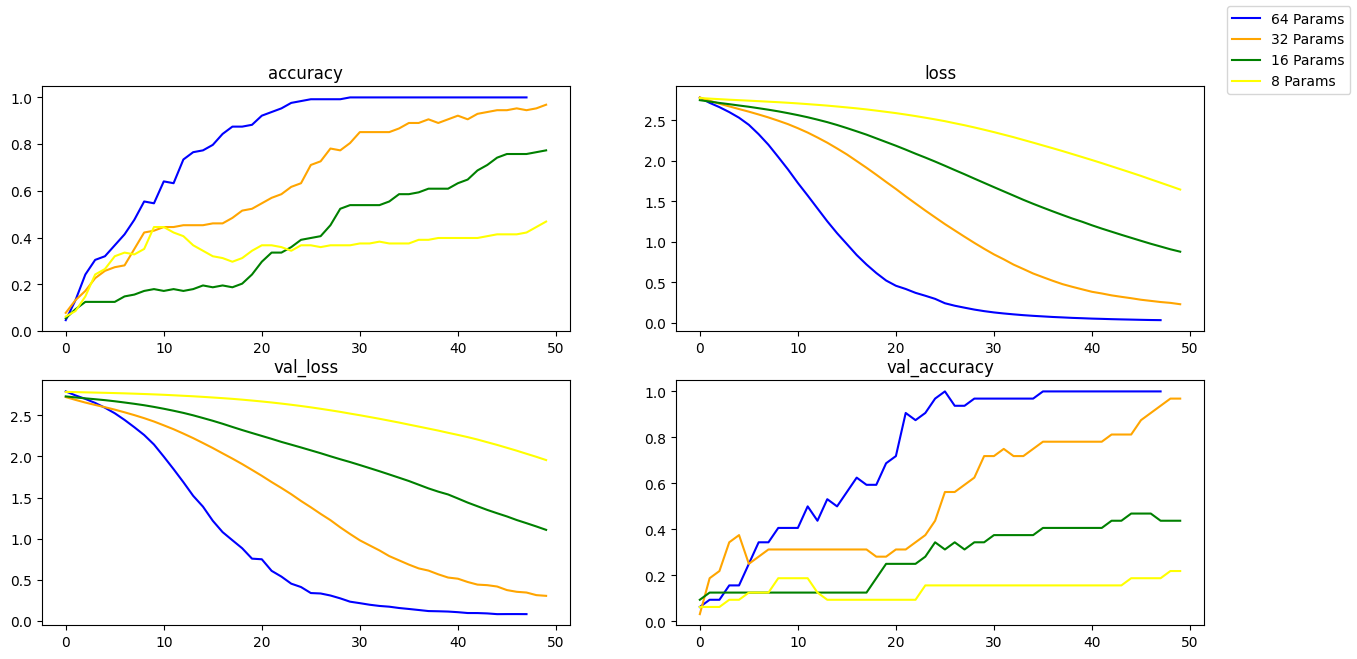

In [23]:
# function to eval all training histories
def eval_training(histories, metrics):
    metrics_vals = []
    axs_len = int(len(metrics)/2)

    for metric in metrics:
        values = []
        for history in histories:
            val = history["history"].history[metric]
            values.append({"metric_val": val, "name": history["name"]})
        metrics_vals.append(values)


    fig, axs = plt.subplots(axs_len, axs_len, figsize=(15, 7))


    colors=["blue", "orange", "green", "yellow", "purple", "red"]
    
    metric_idx = 0
    for i in range(0, axs_len):
        for y in range(0, axs_len):
            axs[i,y].set_title(metrics[metric_idx])
            
            for x in range(0, len(metrics_vals[metric_idx])):
                axs[i, y].plot(metrics_vals[metric_idx][x]['metric_val'], colors[x], label=metrics_vals[metric_idx][x]["name"])
            
            metric_idx += 1


    # https://stackoverflow.com/questions/9834452/how-do-i-make-a-single-legend-for-many-subplots
    
    handles, labels = axs.flat[len(metrics)-1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')

# evaluate all histories
eval_training(histories, ['accuracy', 'loss', 'val_loss', 'val_accuracy'])

In [24]:
def evaluate_on_test(trained_models):
    final_values = []

    for model in trained_models:
        eval_score = model['model'].evaluate(model["X_test"], model["y_test"], verbose=0)

        start_time = time.time()
        pred = model['model'].predict(model["X_test"], verbose = 0)
        stop_time = time.time()

        duration = stop_time - start_time
        final_values.append({'accuracy': eval_score[1], 'inference_time': duration, 'name': model['name']})


    for value in final_values:
        print('model: ' + value['name'])
        print('Results: ' + 'Accuracy: ' + str(value['accuracy']) + ' Inference_time: ' + str(round(value['inference_time']*1000, 3)) + ' Milliseconds')
    
    return final_values 

results = evaluate_on_test(trained_models)

model: 64 Params
Results: Accuracy: 1.0 Inference_time: 286.998 Milliseconds
model: 32 Params
Results: Accuracy: 0.96875 Inference_time: 283.0 Milliseconds
model: 16 Params
Results: Accuracy: 0.4375 Inference_time: 277.049 Milliseconds
model: 8 Params
Results: Accuracy: 0.21875 Inference_time: 284.001 Milliseconds


## Evaluation on Test-set

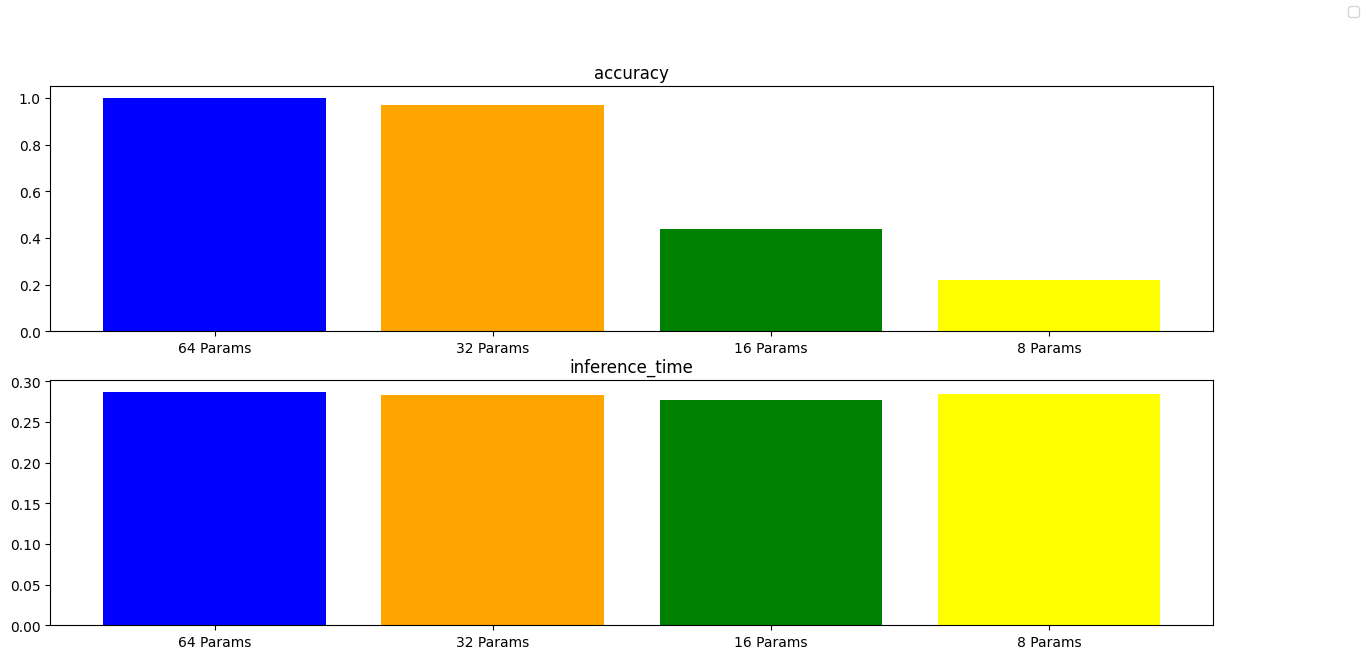

In [25]:
def evaluate_results(results, metrics):
    metrics_vals = []

    for metric in metrics:
        values = []
        for result in results:
            val = result[metric]
            values.append({"metric_val": val, "name": result["name"]})
        metrics_vals.append(values)


    fig, axs = plt.subplots(2, figsize=(15, 7))


    colors=["blue", "orange", "green", "yellow"]


    
    metric_idx = 0
    for i in range(0, 2):
        axs[i].set_title(metrics[metric_idx])
        
        vals = []
        model_cats = []
        for x in range(0, len(metrics_vals[metric_idx])):
            vals.append(metrics_vals[metric_idx][x]['metric_val'])
            model_cats.append(metrics_vals[metric_idx][x]['name'])
        axs[i].bar( model_cats, vals, color=colors)
        metric_idx += 1


    # https://stackoverflow.com/questions/9834452/how-do-i-make-a-single-legend-for-many-subplots
    
    handles, labels = axs.flat[len(metrics)-1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')
    

evaluate_results(results, ['accuracy', 'inference_time'])

# Results

## Comparison of Parameters 

As can be seen in the results above, for my particular models, 32 and 64 Params performed by far the best with accuracy scores of 96.8% and 100%.
At 16 Params we already have a drop to about only 43.8%.
For one, it seems the model will get worse the lower we go with the value, and doesn't really increase in prediction time as we go higher, since the model with 64 params took only 2ms longer to predict than the model with 8.

## Comparison to the 1$ Gesture Recognizer

In terms of accuracy, its hard to compare the 1$ Dollar recognizer directly, but judging from my testing it should also be at above 90%. 
Even when the 1$ dollar recognizer would lack in terms of accuracy slightly, the speed of the predictions (2-3ms) is about 100x lower than the lstm.
For some practical applications, especially for gestures and devices with way less power like a desktop PC, this makes the $1 recognizer better in my Opinion.
When sufficient computing power is provided and it is crucial to get the best accuracy in the chosen application, I would however suggest the usage of a lstm.
